# Networking for Big Data - Project
- Jonas Barth 2050678
- Susanna Bravi 1916681
- Eric Rubia Aguilera 2049558

# Part A
#### 1. Extract general info from your trace using capinfos

In [ ]:
!capinfos -A _00000_20190410070000.pcap

#### 2. Time Evaluation between Sequential and Parallel reading

#### 3. Extract the IP which generates the highest amount as sender traffic, evaluate the bit rate (0.1 sec) for the 6 IP addresses mostly used as endpoint


In [2]:
import pyshark
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import copy
import sys
import shutil
import os
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")


In [3]:
# It takes about 2 minutes (or more) to import the pkl file
dataFrame = pd.read_feather("packets.feather")
len(dataFrame)

832768

In [ ]:
#dataFrame.head()
source = dataFrame.groupby(["IP_SRC"])
len(source) #we have 4548 different sources
# what is the source that sends more pckts?

In [ ]:
data_couple = dataFrame.groupby(["IP_SRC"])[['length']].agg('sum')
print(data_couple.sort_values(by=['length'], ascending=False).head(10))

In [ ]:
max = data_couple.max()
print(data_couple.loc[data_couple['length'] == int(max.iloc[0])])
#so maybe the ip source that generates more traffic is 150.57.136.251

In [ ]:
onlyTheSource = dataFrame[dataFrame["IP_SRC"] == "150.57.136.251"]

data_destination = onlyTheSource.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(6)

data_6IPs = onlyTheSource.groupby(["IP_DST"])
print(data_destination)

rowlength = int(data_destination.shape[0]/2)


In [ ]:
fig = px.histogram(dataFrame["length"], x='length',
                   nbins=15, 
                   title='Histogram of Packet Length',
                   labels={'length':'Packet Length (Byte)'},
                   opacity=0.8,
                   log_y=False,
                   color_discrete_sequence=['#2a9d8f'],
                   text_auto=True,
                   template='plotly_white',
                   width=800, 
                   height=400)
fig.update_layout(
    yaxis_title_text='Frequency',
    bargap=0.2, # gap between bars of adjacent location coordinates
    #margin=dict(l=20, r=20, t=20, b=20),
    #paper_bgcolor="gray"
)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)
fig.show(renderer='notebook')

In [ ]:
def bitRate(data, step_sec = 0.1):
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    
    data["time"] -= data.iloc[0]["time"]
    start = data.iloc[0]["time"]
    finish = data.iloc[-1]["time"]
    
    #print("Start: ",start)
    #print("Finish: ",finish)
    
    step = finish/ step_sec
    finish = start + step_sec
    value = []
    #print(step)
    for i in range(int(step)):
    
        #From Byte to bit - selection of the time interval between the start and the end of a single time slot
        val = np.sum(data[(data["time"]>=start) & (data["time"]<finish)]["length"]*8)
        if not np.isnan(val):
            value.append(val/step_sec)
        start = finish 
        finish = start + step_sec
        
    return value


In [ ]:
fig, axs = plt.subplots(figsize=(20,12), 
                        nrows=2, ncols=rowlength,     
                        gridspec_kw=dict(hspace=0.4)) 
#fig.tight_layout()
targets = zip(data_destination.index, axs.flatten())
for i, (key, ax) in enumerate(targets):
    print(key)
    #ax.plot(data_couple.get_group(key)["length"])
    ax.plot(bitRate(data_6IPs.get_group(key)),marker = "o")
    ax.set_title(key)
    ax.set_xlabel("T (sec)")
    ax.set_ylabel("bit/sec")
    #ax.set_yscale('log')
fig.suptitle('TOP 6 IP Dst for 150.57.136.251', fontsize=16)
#plt.savefig("TOP 6 IP Dst for MyIP")
plt.show()

#If now the step in bit rate is 0.1 second, the label of the x axes remains in seconds?

#### 4. Top 5 Destination IP (received bytes) and Top 5 Source IP (sent bytes)


In [ ]:
data_top5dest = dataFrame.groupby(["IP_DST"])[['length']].agg('sum').sort_values(by=['length'], ascending=False).head(5)
data_top5dest

In [ ]:
bar_dest = px.bar(data_top5dest, y=data_top5dest.index[:], x = data_top5dest['length'][:]/1e3,
                    title='Top 5 destinations',
                    opacity=0.8,
                    color_discrete_sequence=['#e5b769'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_dest.update_layout(
    yaxis_title_text ='Destinations',
    xaxis_title_text ='Received Bytes')# gap between bars of adjacent location coordinates
bar_dest.update_yaxes(tickfont_family="Arial Black")
bar_dest.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)



In [ ]:
data_top5source = data_couple.sort_values(by=['length'], ascending=False).head(5)

In [ ]:
bar_source = px.bar(data_top5source, y=data_top5source.index[:], x = data_top5source['length'][:]/1e3,
                    title='Top 5 sources',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)
bar_source.update_layout(
    yaxis_title_text ='Sources',
    xaxis_title_text ='Bytes Sent')
bar_source.update_yaxes(tickfont_family="Arial Black")
bar_source.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

#### 5. Evaluate bitRate considering all the trace with 3 different sampling rate

In [ ]:
bit_plot = px.line(dataFrame,
              x=[ i*0.1 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))))+1)],
              y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.1))),
              template='plotly_white',
              title='Total bit rate',
              markers=True)
bit_plot['data'][0]['showlegend'] = True
bit_plot['data'][0]['name'] = '0.1 sec'
bit_plot.add_scatter(x=[ i*0.4 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.4))),name="0.4 sec")
bit_plot.add_scatter(x=[ i*0.8 for i in range(1,len(list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))))+1)], 
                y=list(map(lambda x: x/1e6, bitRate(dataFrame,0.8))),name="0.8 sec")
bit_plot.update_layout(
    yaxis_title_text ='Mbps',
    xaxis_title_text ='Time(s)')


#### 6. GeoLocal Referenciation of the 5 sessions with the highest amount of traffic generated

In [ ]:
from ip2geotools.databases.noncommercial import DbIpCity
import folium

In [ ]:
def geo_infos(ip_src_list, ip_dst_list):

  src_geo_info = []
  dst_geo_info = []
  i = 0

  for j in range(len(ip_src_list)):
    try:
      src_response = DbIpCity.get(ip_src_list[j], api_key='free')
      dst_response = DbIpCity.get(ip_dst_list[j], api_key='free')
    except:
      continue
    if src_response.latitude == None or dst_response.latitude == None: 
      continue
    i +=1
    src_geo_info.append([src_response.latitude, src_response.longitude, src_response.region])
    dst_geo_info.append([dst_response.latitude, dst_response.longitude, dst_response.region])
    if i == 10: break

  return src_geo_info, dst_geo_info


In [ ]:
data_couple = copy.deepcopy(dataFrame)
#Change your local IP with the one used to navigate on the Web
#data_couple["IP_SRC"]= data_couple["IP_SRC"].replace({'192.168.43.28':'46.37.14.27'})
#data_couple["IP_DST"] = data_couple["IP_DST"].replace({'192.168.43.28':'46.37.14.27'})
df_srcdst = list(zip(data_couple.IP_SRC, data_couple.IP_DST))

mostcommon_srcdst = Counter(df_srcdst).most_common(5)
mostcommon_srcdst

In [ ]:
list_src = []
list_dst = []

for i in range(len(mostcommon_srcdst)):
    list_src.append(mostcommon_srcdst[i][0][0]) #src pos 0
    list_dst.append(mostcommon_srcdst[i][0][1]) #dst pos 1

#src_geo, dst_geo = geo_infos(list(top_10_flows['ip_src']), list(top_10_flows['ip_dst']))

#Sigle Couple
#src_geo, dst_geo = geo_infos(['185.86.84.30'],['46.37.14.27'])
#5 Couples
src_geo, dst_geo = geo_infos(list_src, list_dst)

src_geo = pd.DataFrame(src_geo, columns=['latitude', 'longitude', 'region'])
dst_geo = pd.DataFrame(dst_geo, columns=['latitude', 'longitude', 'region'])

print("Data:  \n")
print(src_geo)
print()
print(dst_geo)
print("\n")

flow_map = folium.Map([0, 0], zoom_start=2, tiles='Stamen Terrain')

for i in range(len(src_geo)):
  folium.Marker([src_geo.loc[i][0], src_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>', 
                icon=folium.Icon(color='green')).add_to(flow_map)
  folium.Marker([dst_geo.loc[i][0], dst_geo.loc[i][1]], popup='<i>Mt. Hood Meadows</i>',  
                icon=folium.Icon(color='red')).add_to(flow_map)
  folium.PolyLine([(src_geo.loc[i][0], src_geo.loc[i][1]), (dst_geo.loc[i][0], dst_geo.loc[i][1])], 
                  color="blue", weight=1.5, opacity=1).add_to(flow_map)

#flow_map.save(folder_image +"Map_top_5_flows.html")
#display(flow_map)

#### 7. 10 Protocol mostly used

In [ ]:
grouped_flows = dataFrame.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
print(grouped_flows)

In [ ]:
grouped_flows.Protocol.value_counts().index #we have only 9 protocols??

In [ ]:
grouped_flows["Protocol"] = grouped_flows["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP",50:"ESP",4:"IPv4",47:"GRE",89:"OSPFIGP",97:"ETHERIP",103:"PIM"}) 
#like this util we do not found the name of the other protocols
#found them in https://www.iana.org/assignments/protocol-numbers/protocol-numbers.xhtml

In [ ]:
bar_protocol = px.bar(grouped_flows["Protocol"], y=grouped_flows.Protocol.value_counts().index, x = grouped_flows.Protocol.value_counts().values,
                    title='Top 9 Protocols used',
                    opacity=0.8,
                    color_discrete_sequence=['#2a9d8f'],
                    text_auto=True,
                    template='plotly_white',
                    width=800, 
                    height=400)

bar_protocol.update_layout(
    yaxis_title_text ='Prtocols',
    xaxis_title_text ='Count')
bar_protocol.update_yaxes(tickfont_family="Arial Black")
bar_protocol.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 8. Port Scanner evaluation (10 Ports mostly used)

In [ ]:
def port_scan (x, dic):
    ''' scan through the ports and update the counter at each import file. 
    save only the info for the well-known ports '''
    for port in x:
        if pd.isnull(port) == False:
            #Well-Known Ports
            if int(port) < 1024:
                if port not in dic.keys():
                    dic[port] = 1
                else:
                    dic[port] += 1
    return(dic)

In [ ]:
#Scanning port analysing pandasDataframe, both for source and destination ports
source_ports = {}
source_ports = port_scan(dataFrame["src_port"], source_ports)
dest_ports = {}
dest_ports = port_scan(dataFrame["dst_port"], dest_ports)

pd.DataFrame.from_dict(source_ports, orient = 'index').to_json('./source_ports.json')
pd.DataFrame.from_dict(dest_ports, orient = 'index').to_json('./dest_ports.json')

sports = pd.read_json('./source_ports.json')
dports = pd.read_json('./dest_ports.json')

sports = sports.reset_index()
dports = dports.reset_index()
sports = sports.rename(columns = {'index':'port', 0:'count'})
dports = dports.rename(columns = {'index':'port', 0:'count'})

sports = sports.sort_values(by = 'count', ascending = False)
dports = dports.sort_values(by = 'count', ascending = False)

In [ ]:
aux=dataFrame[dataFrame['dst_port']==-1]
aux=aux[aux['Protocol']==17]
#aux

# We observe that these pkts have a defult -1 for source and destination number since they seem to be related to
#control rather than to messages, but there are some UDP pkts... weirddddddo

In [ ]:
#PROBLEM ?
dports.port.value_counts().index #who is -1 ???

In [ ]:
#dports['port']=dports['port'].astype('string')
dports_10 = dports.sort_values(by=['count'], ascending=False).head(10)
dports_10["port"] = dports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1 - ICMP",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 
#sports['port']=sports['port'].astype('string')
sports_10 = sports.sort_values(by=['count'], ascending=False).head(10)
sports_10["port"] = sports_10["port"].replace({443:"443 - HTTPS",80:"80 - HTTP",-1:"-1 - ICMP",53:"53 - DNS",873:"873 - rsync",993:"993 - IMAP4",22:"22 -SSH",161:"161 - SNMP ",25:"25 - SMTP",123:"123 - NTP"}) 

In [ ]:
port_plot = px.bar(dports_10,x=dports_10['port'],y=dports_10['count'],text_auto=True,
                    title='Top 10 Destination ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
port_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
port_plot.update_xaxes(tickfont_family="Arial Black")
port_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

In [ ]:
sport_plot = px.bar(sports_10,x=sports_10['port'],y=sports_10['count'],text_auto=True,
                    title='Top 10 Source ports used',
                    opacity=0.8,
                    color_discrete_sequence=['#86bbd8'],
                    template='plotly_white',
                    width=800, 
                    height=400)
'''
sport_plot.update_layout(
    yaxis_title_text ='Ports',
    xaxis_title_text ='Count')
sport_plot.update_xaxes(tickfont_family="Arial Black")
sport_plot.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)'''

In [ ]:
#maybe we prefer them together?
fig = make_subplots(rows=1, cols=2,subplot_titles=("Destination Ports", "Source Ports"),shared_yaxes=True)
fig.add_trace(port_plot['data'][0], row=1, col=1)
fig.add_trace(sport_plot['data'][0], row=1, col=2)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="10 most used ports",
    xaxis_title_text ='Ports',
    yaxis_title_text ='Count')
fig.update_layout(template='plotly_white')
fig.update_xaxes(tickfont_family="Arial Black")
fig.update_xaxes(title_text="ports", row=1, col=2)
fig.update_yaxes(title_text="count", row=1, col=2)
fig.update_traces(textfont_size=9, textangle=0, textposition="outside", cliponaxis=False)

### 9. InterArrival Time boxplot between TCP and UDP Sessions

In [ ]:
import copy
from collections import Counter

def InterArrivalTime(data):
    val = np.array(data["time"])
    #Calculate the n-th discrete difference along the given axis
    return np.diff(val)

data_protocol = copy.deepcopy(dataFrame[dataFrame["Protocol"].isin([6,17])])
data_protocol["Protocol"] = data_protocol["Protocol"].replace({1:"ICMP",6:"TCP",17:"UDP"})

print(Counter(data_protocol["Protocol"]))

In [ ]:
box_len = px.box(data_protocol, y="length", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#Seems like we have small pkts
#From the histogram at the beginning of the document we can see that almost all the pkts are < 2000 byte
#Let's try to do for only pkts of this size

In [ ]:
data_protocol_2000 = data_protocol[data_protocol["length"]<= 2000]
box_len_2000 = px.box(data_protocol_2000, y="length", x='Protocol', color='Protocol',template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
# The TCP box is quite big so the interquantile range is large... so we have data that is quite variable
# The UDP's box is smaller that the TCP one so here the variance is smaller and also the size of the pckts is smaller that the TCP. UDP also does not have pckts pf size bigger that 1500 byte while TCP has
# a median equal to 1299 so the 50% of the pckts are bigger taht 1300 bytes.

In [ ]:
np.quantile(np.array(data_protocol['length']),q=0.88)

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=("Original data UDP","Original data TCP", "Pckts whit length < 2000 bytes UDP","Pckts whit length < 2000 bytes TCP"))
fig.add_trace(box_len['data'][0], row=1, col=1)
fig.add_trace(box_len['data'][1], row=1, col=2)
fig.add_trace(box_len_2000['data'][0], row=1, col=3)
fig.add_trace(box_len_2000['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Packets length")
fig.update_layout(template='plotly_white',showlegend=False)

In [ ]:
soloUDP = data_protocol[data_protocol["Protocol"]=='UDP']
np.max(np.array(soloUDP['length']))
#no UDP pckts bigger than 1500 bytes.. 
#maybe we should know why from the theory? 

In [ ]:
#Inter arrival time
tcp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="TCP"]
udp_data = data_protocol_2000[data_protocol_2000["Protocol"]=="UDP"]

inteArr_TCP= []
for elem in tcp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    #groupby tuple (key,dataframe)
    inteArr_TCP += InterArrivalTime(elem[1]).tolist()

inteArr_UDP = []
for elem in udp_data.groupby(['IP_SRC', 'IP_DST', 'Protocol', 'src_port', 'dst_port']):
    inteArr_UDP += InterArrivalTime(elem[1]).tolist()


val_ = inteArr_TCP + inteArr_UDP

label_TCP = [ "TCP" for i in range(len(inteArr_TCP))]
label_UDP =[ "UDP" for i in range(len(inteArr_UDP))]

lab_ = label_TCP + label_UDP

d = {'Protocol': lab_, 'IntArrTime': val_}
df = pd.DataFrame(data=d)

In [ ]:
print("Mean InterArrivalTime TCP Session: %.4f"% np.mean(np.array(inteArr_TCP)))
print("Mean InterArrivalTime UDP Session: %.4f"% np.mean(np.array(inteArr_UDP)))
#the TCP interarrival time is smaller than the UDP
#median?
print("Median InterArrivalTime TCP Session: %.5f"% np.median(np.array(inteArr_TCP)))
print("Median InterArrivalTime UDP Session: %.5f"% np.median(np.array(inteArr_UDP)))
# 3rd quartile
print("3rd quartile InterArrivalTime TCP Session: %.5f"% np.quantile(np.array(inteArr_TCP),q=0.75))
print("3rd quartile InterArrivalTime UDP Session: %.5f"% np.quantile(np.array(inteArr_UDP),q=0.75))
#After this make sense to plot it for values less that 0.00004 (median of TCP) seconds and 0.0009 (median of UDP)

In [ ]:
df1 = df[df["IntArrTime"] <  0.0009]
fig1 = px.box(df1, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#fig.show()

In [ ]:
df2 = df[df["IntArrTime"] < 0.00004]
fig2 = px.box(df2, y="IntArrTime", x='Protocol', color='Protocol', template='plotly_white',color_discrete_sequence=[ '#e5b769' ,'#2a9d8f'])
#fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=4,subplot_titles=("UDP < 0.009 s","TCP < 0.009 s", "UDP < 0.00004","TCP < 0.00004"))
fig.add_trace(fig1['data'][0], row=1, col=1)
fig.add_trace(fig1['data'][1], row=1, col=2)
fig.add_trace(fig2['data'][0], row=1, col=3)
fig.add_trace(fig2['data'][1], row=1, col=4)
fig.update_layout(
    height=600, 
    width=1500,
    title_text="Interarrival time",
    yaxis_title_text='Time (s)')
fig.update_layout(template='plotly_white',showlegend=False)

### 10. Develope your own analysis (e.g. Topology of the network using networkx or evaluation about a variable such as TTL) 

In [4]:
import networkx as nx
import random
from networkx.algorithms import approximation as apx
random.seed(26111998) # COMPLEANNO DI MAVI <3

In [5]:
Dest_IPs,Source_IPs=list(dataFrame['IP_DST']),list(dataFrame['IP_SRC'])
len(np.unique(Dest_IPs+Source_IPs))

18413

In [6]:
data_udp=dataFrame[dataFrame['Protocol']==17]
data_tcp=dataFrame[dataFrame['Protocol']==6]
data_ICMP=dataFrame[dataFrame['Protocol']==1]
data_transport=dataFrame[(dataFrame['Protocol']==17) | (dataFrame['Protocol']==6)]


In [7]:
Dest_IPs_UDP,Source_IPs_UDP=list(data_udp['IP_DST']),list(data_udp['IP_SRC'])
print("There are ",len(np.unique(Dest_IPs_UDP+Source_IPs_UDP))," nodes sending and receiving UDP pckts")
Dest_IPs_TCP,Source_IPs_TCP=list(data_tcp['IP_DST']),list(data_tcp['IP_SRC'])
print("There are ",len(np.unique(Dest_IPs_TCP+Source_IPs_TCP))," nodes sending and receiving TCP pckts")
Dest_IPs_ICMP,Source_IPs_ICMP=list(data_ICMP['IP_DST']),list(data_ICMP['IP_SRC'])
len(np.unique(Dest_IPs_ICMP+Source_IPs_ICMP))
print("There are ",len(np.unique(Dest_IPs_ICMP+Source_IPs_ICMP)),"nodes sending and receiving ICMP pckts")

There are  4229  nodes sending and receiving UDP pckts
There are  4660  nodes sending and receiving TCP pckts
There are  10162 nodes sending and receiving ICMP pckts


#### UDP GRAPH

In [8]:
data_udp=data_udp.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
data_udp.drop('tot_len',axis=1,inplace=True)
UDP=data_udp[['IP_SRC','IP_DST']]
udp_count=dict(UDP.value_counts())
l=[]
for i in range(len(data_udp)):
    l.append(udp_count[(data_udp.iloc[i]['IP_SRC'],data_udp.iloc[i]['IP_DST'])])
data_udp['Num Flows']=l
#data_udp


In [10]:
Graph_UDP=nx.DiGraph()

for _,i in data_udp.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_UDP.edges:
        Graph_UDP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_UDP.add_edge(node_a,node_b)
        Graph_UDP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_UDP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [11]:
#Graph_UDP.get_edge_data("96.226.38.235","131.137.9.254")
#np.unique([i[0] for i in Graph_UDP.get_edge_data("96.226.38.235","131.137.9.254")['List']])
# Runnare per vedere un essempio dei attributi dell'arco

#### TCP GRAPH

In [12]:
data_tcp=data_tcp.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
data_tcp.drop('tot_len',axis=1,inplace=True)
TCP=data_tcp[['IP_SRC','IP_DST']]
tcp_count=dict(TCP.value_counts())
l=[]
for i in range(len(data_tcp)):
    l.append(tcp_count[(data_tcp.iloc[i]['IP_SRC'],data_tcp.iloc[i]['IP_DST'])])
data_tcp['Num Flows']=l
#data_tcp


In [13]:
Graph_TCP=nx.DiGraph()

for _,i in data_tcp.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_TCP.edges:
        Graph_TCP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_TCP.add_edge(node_a,node_b)
        Graph_TCP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_TCP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [14]:
#Graph_TCP.get_edge_data("95.36.218.85","202.9.24.18")

#### ICMP GRAPH

In [15]:
data_ICMP=data_ICMP.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
data_ICMP.drop('tot_len',axis=1,inplace=True)
ICMP=data_ICMP[['IP_SRC','IP_DST']]
ICMP_count=dict(ICMP.value_counts())
l=[]
for i in range(len(data_ICMP)):
    l.append(ICMP_count[(data_ICMP.iloc[i]['IP_SRC'],data_ICMP.iloc[i]['IP_DST'])])
data_ICMP['Num Flows']=l
#data_ICMP


In [16]:
Graph_ICMP=nx.DiGraph()

for _,i in data_ICMP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_ICMP.edges:
        Graph_ICMP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_ICMP.add_edge(node_a,node_b)
        #In this case we could simply go for a directed graph without attributes because the numflow is always 1 and the list is [-1,-1] for all
        Graph_ICMP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_ICMP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

In [17]:
Graph_ICMP.get_edge_data("8.247.137.248","203.122.132.249")

{'Num Flow': 1, 'List': [(-1, -1)]}

### Visualization of the topology of the 3 graphs

In [18]:
sample_UDP=data_udp.sample(400)
sample_TCP=data_tcp.sample(400)
sample_ICMP=data_ICMP.sample(400)

In [19]:
Graph_subset_UDP=nx.DiGraph()

for _,i in sample_UDP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_UDP.edges:
        Graph_subset_UDP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_UDP.add_edge(node_a,node_b)
        Graph_subset_UDP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_UDP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

Graph_subset_TCP=nx.DiGraph()

for _,i in sample_TCP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_TCP.edges:
        Graph_subset_TCP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_TCP.add_edge(node_a,node_b)
        Graph_subset_TCP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_TCP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

Graph_subset_ICMP=nx.DiGraph()

for _,i in sample_ICMP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_ICMP.edges:
        Graph_subset_ICMP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_ICMP.add_edge(node_a,node_b)
        Graph_subset_ICMP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_ICMP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]


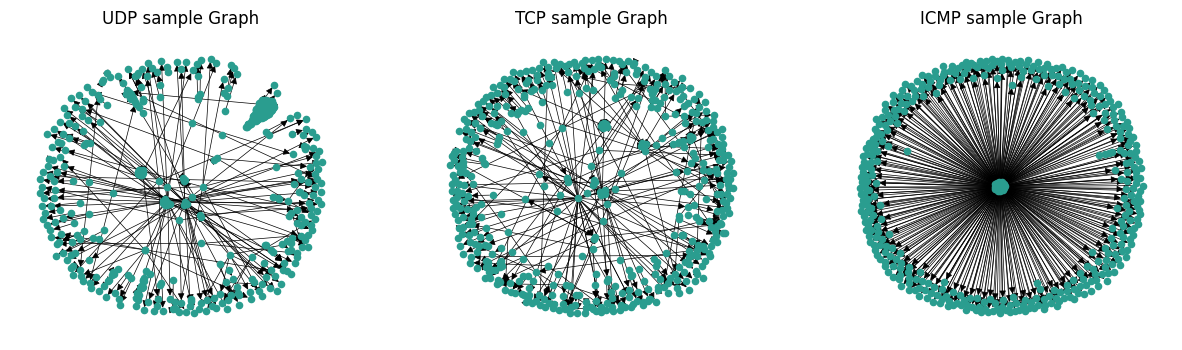

In [20]:
fig, axes = plt.subplots(1,3, figsize=(15,4))
nx.draw(Graph_subset_UDP,node_size = 20, width = 0.5, node_color = '#2a9d8f', ax=axes[0])
nx.draw(Graph_subset_TCP,node_size = 20, width = 0.5, node_color = '#2a9d8f', ax=axes[1])
nx.draw(Graph_subset_ICMP,node_size = 20, width = 0.5, node_color = '#2a9d8f', ax=axes[2])

axes[0].set_title("UDP sample Graph")
axes[1].set_title("TCP sample Graph")
axes[2].set_title("ICMP sample Graph")

plt.show()


After this overview of the topology we have decided to put together the TCP and UDP graphs, while the ICMP graph has a particular topology with fewer sources and more destinations than the other two mentioned protocols. <br>
This is beacause the ICMP protocol is used for troubleshooting, the sources want to know if the destinations are reacheable.

In [21]:
#So let's merge them
data_transport=dataFrame[(dataFrame['Protocol']==17) | (dataFrame['Protocol']==6)]
Dest_IPs_t,Source_IPs_t=list(data_transport['IP_DST']),list(data_transport['IP_SRC'])
len(np.unique(Dest_IPs_t+Source_IPs_t))
data_transport = data_transport.groupby(['IP_SRC', 'IP_DST', 'src_port', 'dst_port', 'Protocol']).agg(tot_len = pd.NamedAgg(column = 'length', aggfunc = 'sum')).reset_index()
data_transport = data_transport.drop('tot_len',axis=1,inplace=False)

In [22]:
TR=data_transport[['IP_SRC','IP_DST']]
t_count=dict(TR.value_counts())
l=[]
for i in range(len(data_transport)):
    l.append(t_count[(data_transport.iloc[i]['IP_SRC'],data_transport.iloc[i]['IP_DST'])])
data_transport['Num Flows']=l

# Creating the new graph for both TCP and UDP
Graph_Transport=nx.DiGraph()

for _,i in data_transport.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_Transport.edges:
        Graph_Transport.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_Transport.add_edge(node_a,node_b)
        Graph_Transport.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_Transport.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]


#PROBLEM WE NEED TO ADD AS AN ATTRIBUTE WITH PROTOCOLS IS USED!

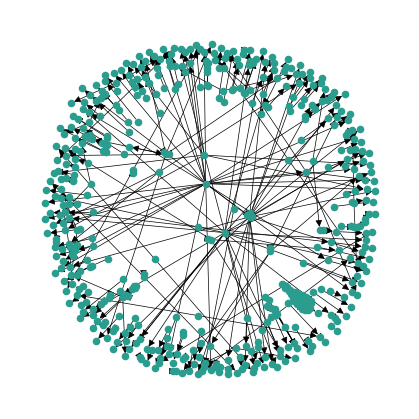

In [28]:
#Drawing a sample of this graph
transport_sample = data_transport.sample(400)

Graph_Sample_T=nx.DiGraph()

for _,i in transport_sample.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_Sample_T.edges:
        Graph_Sample_T.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_Sample_T.add_edge(node_a,node_b)
        Graph_Sample_T.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_Sample_T.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]
plt.figure(figsize=(4,4))
nx.draw(Graph_Sample_T,node_size = 20, width = 0.5, node_color = '#2a9d8f', font_size = 6)


### Analysis of the metrics for the two Graphs

In [29]:
# How many nodes we have?
print("Number of nodes: %.0f"% nx.number_of_nodes(Graph_ICMP))
print("Number of edges: %.0f"% nx.number_of_edges(Graph_ICMP))
# Is the graph connected?
print("Is the graph connected? %.0f"% apx.node_connectivity(Graph_ICMP)) # seems no? so it is disconnected
# Node connectivity is equal to the minimum number of nodes that must be removed to disconnect G or render it trivial. 
# By Menger’s theorem, this is equal to the number of node independent paths (paths that share no nodes other than source and target).


Number of nodes: 10162
Number of edges: 10615
Is the graph connected? 0


In [31]:
# Making also the undirected version
undirected_ICMP = nx.Graph()
undirected_ICMP.add_edges_from(Graph_ICMP.edges())
undirected_transport = nx.Graph()
undirected_transport.add_edges_from(Graph_Transport.edges()) 

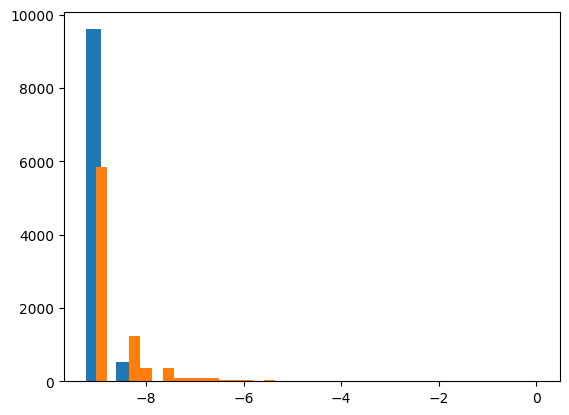

In [41]:
# Degree of the two Graphs
Counter(nx.degree_histogram(undirected_ICMP)) #almost all the nodes have degree 0

#fig, axes = plt.subplots(1,2, figsize=(15,4))
icmp_hist = plt.hist(np.log(list(nx.degree_centrality(Graph_ICMP).values())),bins=30)
transport_hist = plt.hist(np.log(list(nx.degree_centrality(Graph_Transport).values())),bins=30)
plt.show()


In [ ]:

# there are lot of nodes that are destination and have a degree centrality near 0.
# Nonetheless there are very few nodes with higher degree centrality

In [ ]:

plt.show()

In [ ]:
print(np.var(list(nx.degree_centrality(Graph_Transport).values())))
print(np.mean(list(nx.degree_centrality(Graph_Transport).values())))

In [ ]:
print(np.var(list(nx.degree_centrality(Graph_ICMP).values())))
print(np.mean(list(nx.degree_centrality(Graph_ICMP).values())))
print(np.var(list(nx.degree_centrality(Graph_ICMP).values()))/np.var(list(nx.degree_centrality(Graph_Transport).values()))) #strange ratio...

In [ ]:
print("Is the graph connected? %.0f"% apx.node_connectivity(undirected_ICMP)) # The graph is not connected and so we cannot calculate clusters and other metrics...

In [ ]:
print(nx.is_directed_acyclic_graph(Graph_ICMP)) # so our graph have cycles and we can not do the longest path (also the other 2)
print(apx.average_clustering(undirected_ICMP)) #no clutsers in ICMP
print(apx.average_clustering(undirected_transport)) #neither for the transport data

# Visualisation of the Graphs (Sample of the Data)

In [315]:
Graph_subset_UDP=nx.DiGraph()

for _,i in sample_UDP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_UDP.edges:
        Graph_subset_UDP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_UDP.add_edge(node_a,node_b)
        Graph_subset_UDP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_UDP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

Graph_subset_TCP=nx.DiGraph()

for _,i in sample_TCP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_TCP.edges:
        Graph_subset_TCP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_TCP.add_edge(node_a,node_b)
        Graph_subset_TCP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_TCP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]

Graph_subset_ICMP=nx.DiGraph()

for _,i in sample_ICMP.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_subset_ICMP.edges:
        Graph_subset_ICMP.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_subset_ICMP.add_edge(node_a,node_b)
        Graph_subset_ICMP.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_subset_ICMP.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]


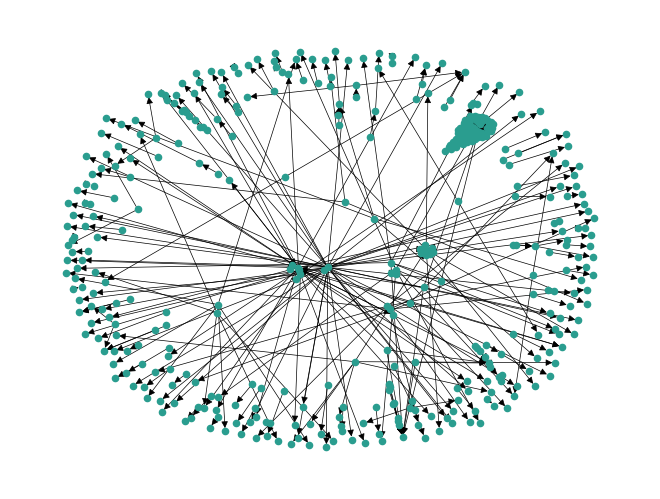

In [316]:
nx.draw(Graph_subset_UDP,node_size = 20, width = 0.5, node_color = '#2a9d8f')
#in this random sample we can see that there are few sources and lot of destinations

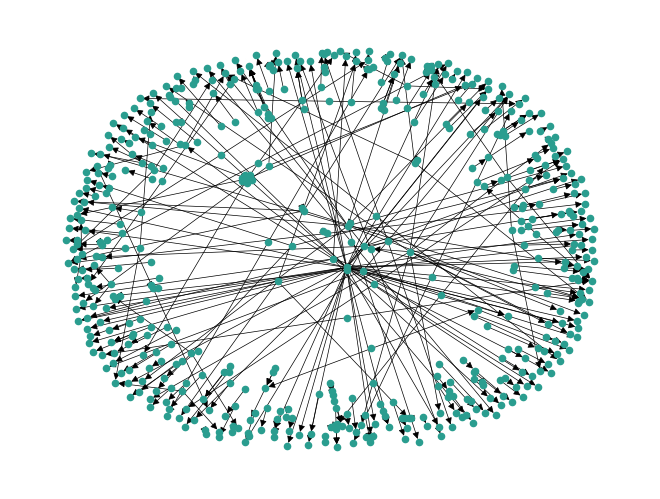

In [317]:
nx.draw(Graph_subset_TCP,node_size = 20, width = 0.5, node_color = '#2a9d8f')

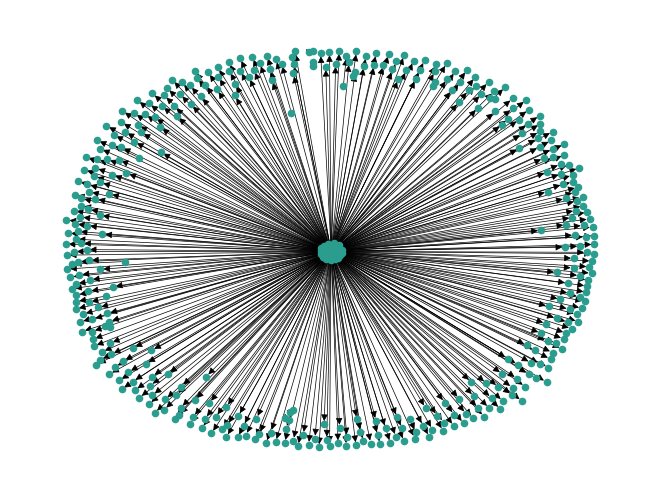

In [318]:
nx.draw(Graph_subset_ICMP,node_size = 20, width = 0.5, node_color = '#2a9d8f', with_labels=False, font_size = 6 )

In [ ]:
TR=data_transport[['IP_SRC','IP_DST']]
t_count=dict(TR.value_counts())
l=[]
for i in range(len(data_transport)):
    l.append(t_count[(data_transport.iloc[i]['IP_SRC'],data_transport.iloc[i]['IP_DST'])])
data_transport['Num Flows']=l


In [ ]:
# Creating the new graph for both TCP and UDP
Graph_Transport=nx.DiGraph()

for _,i in data_transport.iterrows():
    node_a=i['IP_SRC']
    node_b=i['IP_DST']
    if (node_a,node_b) in Graph_Transport.edges:
        Graph_Transport.edges[node_a,node_b]['List']+=[(i['src_port'],i['dst_port'])]
    else:
        Graph_Transport.add_edge(node_a,node_b)
        Graph_Transport.edges[node_a,node_b]['Num Flow']=i['Num Flows']
        Graph_Transport.edges[node_a,node_b]['List']=[(i['src_port'],i['dst_port'])]


#PROBLEM WE NEED TO ADD AS AN ATTRIBUTE WITH PROTOCOLS IS USED!

Planar
bipartited
connected
acyclic